In [1]:
import pandas as pd
import numpy as np 
import pickle
import xgboost as xgb
import time
import graphviz
import matplotlib as plt
import re

In [2]:
START_NOTEBOOK = time.time()
SUB=False
AVE= False
NMF_DIM = 40

In [3]:
x_train , x_test , y_train , y_test = pickle.load(open('../saved_datasets/19-3-19,pipeline_A_reduced_frommaster,dateback=18/xtrain_xtest_ytrain_ytest.pickle','rb'))

In [4]:
df = x_train[0].copy()
df['target'] = y_train[0]
df.groupby('date_block_num')

In [5]:
df.date_block_num.unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [6]:
dft = x_test[0].copy()
dft['target'] = y_test[0]
dft.groupby('date_block_num',as_index=False).new_item.mean()

,date_block_num,new_item
0,33,0.126667


In [7]:
df = x_train[1].copy()
df['target'] = y_train[1]
g = df.groupby('date_block_num',as_index=False).new_item.mean()
g

,date_block_num,new_item
0,18,0.047799
1,19,0.039290
2,20,0.054357
3,21,0.088096
4,22,0.072762
5,23,0.071461
6,24,0.032090
7,25,0.037172
8,26,0.055245
9,27,0.047845


In [8]:
g.plot(x='date_block_num',kind='bar')

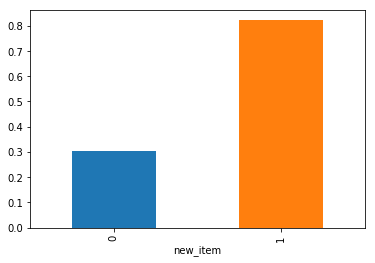

In [9]:
df = x_train[0].copy()
df['target'] = y_train[0]
df.groupby('new_item').target.mean().plot(kind='bar')

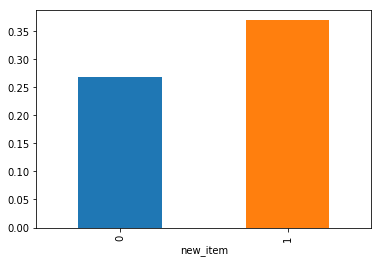

In [10]:
dft = x_test[0].copy()
dft['target'] = y_test[0]
dft.groupby('new_item').target.mean().plot(kind='bar')

# check prop_median_item_price

In [11]:
df = x_train[0].copy()
df['target'] = y_train[0]
np.quantile(df.prop_median_item_price,0.2,)

1.0

In [12]:
np.mean(df.prop_median_item_price.isna())

0.0

# Preprocessing

Try averaging some features

In [13]:
def ave_feats(df):
    feats = [     
     'sum_item_sales_back_',
     'sum_shop_sales_back_',
     'item_cnt_month_back_',
     'sum_item_cat_sales_back_',
     'sum_city_back_',
     'sum_itemtype_back_',
     'sum_iteminfo_back_'
            ]
    df = df.copy()
    for feat in feats:
        print('averaging on '+feat+'...')
        for i in np.arange(1,18,3):
            df['ave_'+feat+str(i)] = (df[feat+str(i)]+df[feat+str(i+1)]+df[feat+str(i+2)])/3
        reduced_cols = [a for a in df.columns.tolist() if not re.match('^'+feat,a)]
        df = df[reduced_cols]
    return df

In [14]:
if AVE:
    x_train = list(map(ave_feats,x_train))
    x_test = list(map(ave_feats,x_test))

Try culling early data

In [15]:
x_train_saved = x_train
y_train_saved = y_train
x_train = []
y_train = []
CUTOFF = 0
for xtrain_el , ytrain_el in zip(x_train_saved,y_train_saved):
    x_train.append(xtrain_el[xtrain_el.date_block_num>CUTOFF])
    y_train.append(ytrain_el[xtrain_el.date_block_num>CUTOFF])

In [16]:
def preproc_model3(x_train,x_test,y_train,y_test):

    x_train = [d.drop(['shop_id','item_id','item_category_id','city','item_type','item_info','month'],axis=1) for d in x_train]
    x_test =  [d.drop(['shop_id','item_id','item_category_id','city','item_type','item_info','month'],axis=1) for d in x_test]
    y_train = [d.clip(0,20) for d in y_train]
    y_test =  [d.clip(0,20) for d in y_test]
    return [x_train,x_test,y_train,y_test]

In [17]:
x_train , x_test , y_train , y_test = preproc_model3(x_train,x_test,y_train,y_test)

## TODO: account for factor adjustment

# Notes

- There are likely too many feats, this would explain immediate overfitting
- rmse withou clipped data is gonna put a lot of focus on large outliers
* consider mean abs error

# Feature Selection

In [18]:
x_train[0].columns.tolist()

['date_block_num',
 'sum_item_sales_back_1',
 'sum_shop_sales_back_1',
 'item_cnt_month_back_1',
 'sum_item_cat_sales_back_1',
 'sum_city_back_1',
 'sum_itemtype_back_1',
 'sum_iteminfo_back_1',
 'sum_item_sales_back_2',
 'sum_shop_sales_back_2',
 'item_cnt_month_back_2',
 'sum_item_cat_sales_back_2',
 'sum_city_back_2',
 'sum_itemtype_back_2',
 'sum_iteminfo_back_2',
 'sum_item_sales_back_3',
 'sum_shop_sales_back_3',
 'item_cnt_month_back_3',
 'sum_item_cat_sales_back_3',
 'sum_city_back_3',
 'sum_itemtype_back_3',
 'sum_iteminfo_back_3',
 'sum_item_sales_back_4',
 'sum_shop_sales_back_4',
 'item_cnt_month_back_4',
 'sum_item_cat_sales_back_4',
 'sum_city_back_4',
 'sum_itemtype_back_4',
 'sum_iteminfo_back_4',
 'sum_item_sales_back_5',
 'sum_shop_sales_back_5',
 'item_cnt_month_back_5',
 'sum_item_cat_sales_back_5',
 'sum_city_back_5',
 'sum_itemtype_back_5',
 'sum_iteminfo_back_5',
 'sum_item_sales_back_6',
 'sum_shop_sales_back_6',
 'item_cnt_month_back_6',
 'sum_item_cat_sales_ba

In [19]:
def feat_selection(x_train,x_test,y_train,y_test):
    FEATS=[
     'first_sale_date_block',
     'new_item',
        'date_block_num',
#     'city',
#     'item_type',
#     'item_info',
     'prop_median_item_price',
     'sum_item_sales_back_1',
     'sum_shop_sales_back_1',
     'item_cnt_month_back_1',
     'sum_item_cat_sales_back_1',
     'sum_city_back_1',
     'sum_itemtype_back_1',
     'sum_iteminfo_back_1',
        
     'sum_item_sales_back_2',
     'sum_shop_sales_back_2',
     'item_cnt_month_back_2',
     'sum_item_cat_sales_back_2',
     'sum_city_back_2',
     'sum_itemtype_back_2',
     'sum_iteminfo_back_2',
        
     'sum_item_sales_back_3',
     'sum_shop_sales_back_3',
     'item_cnt_month_back_3',
     'sum_item_cat_sales_back_3',
     'sum_city_back_3',
     'sum_itemtype_back_3',
     'sum_iteminfo_back_3',
        
     'sum_item_sales_back_4',
     'sum_shop_sales_back_4',
     'item_cnt_month_back_4',
     'sum_item_cat_sales_back_4',
     'sum_city_back_4',
     'sum_itemtype_back_4',
     'sum_iteminfo_back_4',
        
     'sum_item_sales_back_5',
     'sum_shop_sales_back_5',
     'item_cnt_month_back_5',
     'sum_item_cat_sales_back_5',
     'sum_city_back_5',
     'sum_itemtype_back_5',
     'sum_iteminfo_back_5',
        
     'sum_item_sales_back_6',
     'sum_shop_sales_back_6',
     'item_cnt_month_back_6',
     'sum_item_cat_sales_back_6',
     'sum_city_back_6',
     'sum_itemtype_back_6',
     'sum_iteminfo_back_6',
        
     'sum_item_sales_back_7',
     'sum_shop_sales_back_7',
     'item_cnt_month_back_7',
     'sum_item_cat_sales_back_7',
     'sum_city_back_7',
     'sum_itemtype_back_7',
     'sum_iteminfo_back_7',
       
     'sum_item_sales_back_8',
     'sum_shop_sales_back_8',
     'item_cnt_month_back_8',
     'sum_item_cat_sales_back_8',
     'sum_city_back_8',
     'sum_itemtype_back_8',
     'sum_iteminfo_back_8',
       
     'sum_item_sales_back_9',
     'sum_shop_sales_back_9',
     'item_cnt_month_back_9',
     'sum_item_cat_sales_back_9',
     'sum_city_back_9',
     'sum_itemtype_back_9',
     'sum_iteminfo_back_9',
       
     'sum_item_sales_back_10',
     'sum_shop_sales_back_10',
     'item_cnt_month_back_10',
     'sum_item_cat_sales_back_10',
     'sum_city_back_10',
     'sum_itemtype_back_10',
     'sum_iteminfo_back_10',
    
     'sum_item_sales_back_11',
     'sum_shop_sales_back_11',
     'item_cnt_month_back_11',
     'sum_item_cat_sales_back_11',
     'sum_city_back_11',
     'sum_itemtype_back_11',
     'sum_iteminfo_back_11',

     'sum_item_sales_back_12',
     'sum_shop_sales_back_12',
     'item_cnt_month_back_12',
     'sum_item_cat_sales_back_12',
     'sum_city_back_12',
     'sum_itemtype_back_12',
     'sum_iteminfo_back_12',
     
     'sum_item_sales_back_13',
     'sum_shop_sales_back_13',
     'item_cnt_month_back_13',
     'sum_item_cat_sales_back_13',
     'sum_city_back_13',
     'sum_itemtype_back_13',
     'sum_iteminfo_back_13',
        
     'sum_item_sales_back_14',
     'sum_shop_sales_back_14',
     'item_cnt_month_back_14',
     'sum_item_cat_sales_back_14',
     'sum_city_back_14',
     'sum_itemtype_back_14',
     'sum_iteminfo_back_14',
        
     'sum_item_sales_back_15',
     'sum_shop_sales_back_15',
     'item_cnt_month_back_15',
     'sum_item_cat_sales_back_15',
     'sum_city_back_15',
     'sum_itemtype_back_15',
     'sum_iteminfo_back_15',
        
     'sum_item_sales_back_16',
     'sum_shop_sales_back_16',
     'item_cnt_month_back_16',
     'sum_item_cat_sales_back_16',
     'sum_city_back_16',
     'sum_itemtype_back_16',
     'sum_iteminfo_back_16',
     
     'sum_item_sales_back_17',
     'sum_shop_sales_back_17',
     'item_cnt_month_back_17',
     'sum_item_cat_sales_back_17',
     'sum_city_back_17',
     'sum_itemtype_back_17',
     'sum_iteminfo_back_17',

     'sum_item_sales_back_18',
     'sum_shop_sales_back_18',
     'item_cnt_month_back_18',
     'sum_item_cat_sales_back_18',
     'sum_city_back_18',
     'sum_itemtype_back_18',
     'sum_iteminfo_back_18',        
        
        
        
     'numdays',
     'month_sales',
     'mean_prevmonth_item_price',
     'std_prevmonth_item_price',
     'median_prevmonth_item_price',
     'median_prevmonth_shop_item_price'
    ]
    
    x_train = [d[FEATS] for d in x_train]
    x_test =  [d[FEATS] for d in x_test]
    return [x_train,x_test,y_train,y_test]

In [20]:
#x_train , x_test , y_train , y_test = feat_selection(x_train,x_test,y_train,y_test)

In [21]:
feat_list= []
feat_list = ['_'+str(x)+'$' for x in range(13,19)]
#feat_list = ['iteminfo','item_cat','city','item_sales']
feat_list

['_13$', '_14$', '_15$', '_16$', '_17$', '_18$']

In [22]:
def quickdrop(df):
    cols_keep = df.columns.tolist()
    for feat in feat_list:
        cols_keep = [c for c in cols_keep if not re.match('.*'+feat,c)]
    return df[cols_keep]

In [23]:
x_train = list(map(quickdrop,x_train))
x_test = list(map(quickdrop,x_test))

In [24]:
#x_train[0].columns.tolist()

# NMF

In [25]:
from sklearn.decomposition import NMF

In [26]:
def downcast_more(df):
    float_cols = [col for col in df if (df[col].dtype=='float64' or df[col].dtype=='float32')]
    int_cols = [col for col in df if (df[col].dtype=='int64' or df[col].dtype=='int32')]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return(df)

In [27]:
x_train_saved = x_train
x_test_saved = x_test

In [28]:
x_train = x_train_saved
x_test = x_test_saved

In [29]:
x_train_saved[0].shape

(4181736, 94)

    xtrain = x_train_saved[0]
    xtest = x_test_saved[0]
    ndim=10
    
    xtrain_reduced = xtrain.filter(regex='_\d+$')
    xtest_reduced = xtest.filter(regex='_\d+$')
    
    reduced_cols = xtrain_reduced.columns.tolist()
    all_cols = xtrain.columns.tolist()
    other_cols = [x for x in all_cols if x not in reduced_cols]
    print('other_cols='+str(other_cols))
#    return 5 , 5
    xtrain_reduced = xtrain_reduced.clip(0)
    xtest_reduced = xtest_reduced.clip(0)
    
    xtrain_other = xtrain[other_cols]
    xtest_other =  xtest[other_cols]
    
    xtrain_reduced = downcast_more(xtrain_reduced)
    xtest_reduced = downcast_more(xtest_reduced)
    
    print(xtrain_reduced.shape)
    print(xtest_reduced.shape)
    numtrain = xtrain_reduced.shape[0]
    numtest = xtest_reduced.shape[0]
    
    concat = pd.concat([xtrain_reduced,xtest_reduced])
    print(concat.shape)
    nmf_obj = NMF(n_components=ndim,random_state=0,verbose=True)
    tformed = nmf_obj.fit_transform(concat)
    
    sep_bool = [True]*numtrain + [False]*numtest
    
    train_out = pd.DataFrame(tformed[sep_bool])
    test_out =  pd.DataFrame(tformed[[not x for x in sep_bool]])
    print(train_out.shape)
    
    train_out = pd.concat([train_out,xtrain_other],axis=1)
    test_out = pd.concat([test_out,xtest_other],axis=1)
    print(train_out.shape)

In [30]:
def nmf_tform(xtrain,xtest,ndim):
    xtrain_reduced = xtrain.filter(regex='_\d+$')
    xtest_reduced = xtest.filter(regex='_\d+$')
    
    reduced_cols = xtrain_reduced.columns.tolist()
    all_cols = xtrain.columns.tolist()
    other_cols = [x for x in all_cols if x not in reduced_cols]
    print('other_cols='+str(other_cols))
#    return 5 , 5
    xtrain_reduced = xtrain_reduced.clip(0)
    xtest_reduced = xtest_reduced.clip(0)
    
    xtrain_other = xtrain[other_cols]
    xtest_other =  xtest[other_cols]
    
    xtrain_reduced = downcast_more(xtrain_reduced)
    xtest_reduced = downcast_more(xtest_reduced)
    
    print(xtrain_reduced.shape)
    print(xtest_reduced.shape)
    numtrain = xtrain_reduced.shape[0]
    numtest = xtest_reduced.shape[0]
    
    concat = pd.concat([xtrain_reduced,xtest_reduced])
    print(concat.shape)
    nmf_obj = NMF(n_components=ndim,random_state=0,verbose=True)
    tformed = nmf_obj.fit_transform(concat)
    
    sep_bool = [True]*numtrain + [False]*numtest
    
    train_out = pd.DataFrame(tformed[sep_bool])
    test_out =  pd.DataFrame(tformed[[not x for x in sep_bool]])
    print(train_out.shape)
    
    train_out = pd.concat([train_out,xtrain_other],axis=1)
    test_out = pd.concat([test_out,xtest_other],axis=1)
    print(train_out.shape)
    
    return train_out , test_out 

In [31]:
xtrain = x_train[0]
xtrain_reduced = xtrain.filter(regex='_\d+$')

In [32]:
#xtrain_reduced.apply(lambda x: all(x>=0),axis=0)

In [33]:
start = time.time()
a,b = nmf_tform(x_train[0],x_test[0],NMF_DIM)
print('BREAK')
#x_train[1] , x_test[1] = nmf_tform(x_train[1],x_test[1],10)
print((time.time()-start)/60)

other_cols=['date_block_num', 'first_sale_date_block', 'new_item', 'numdays', 'month_sales', 'mean_prevmonth_item_price', 'std_prevmonth_item_price', 'median_prevmonth_item_price', 'median_prevmonth_shop_item_price', 'prop_median_item_price']
(4181736, 84)
(214200, 84)
(4395936, 84)
violation: 1.0
violation: 0.27163565240724663
violation: 0.19527972880612648
violation: 0.1400305993270581
violation: 0.10368907213713535
violation: 0.07853508310462783
violation: 0.05859392503104258
violation: 0.044505802145453244
violation: 0.03499896313594609
violation: 0.02891637521394989
violation: 0.02503619660140835
violation: 0.02251454373110408
violation: 0.02125281293965995
violation: 0.021520006400216337
violation: 0.02181349291674132
violation: 0.019803449561291975
violation: 0.017596595623089
violation: 0.01596944898027255
violation: 0.014420109186503926
violation: 0.013149772055137832
violation: 0.01213801854216008
violation: 0.011407118622974605
violation: 0.010907152140957518
violation: 0.01

In [34]:
x_train[0] = a
x_test[0] = b

In [35]:
#x_train[0]

In [36]:
#dfa


In [37]:
#[not x for x in [True,False]]

# Fitting

In [38]:
model = xgb.XGBRegressor(
    seed=0,
    max_depth=4,
    learning_rate=0.5,
    n_estimators=1000,
    objective='reg:linear',
    nthread=7,
    #min_child_weight=600,
    colsample_bytree=0.5,
    subsample=0.5
)
eval_set = [(x_train[0],y_train[0]),(x_test[0],y_test[0])]

In [39]:
model.fit(
    verbose=True,
    X=x_train[0],
    y=y_train[0],
    eval_set=eval_set,
    early_stopping_rounds=50
)

[0]	validation_0-rmse:1.11145	validation_1-rmse:1.02189
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.08181	validation_1-rmse:0.998013
[2]	validation_0-rmse:1.06897	validation_1-rmse:0.989749
[3]	validation_0-rmse:1.05876	validation_1-rmse:0.98456
[4]	validation_0-rmse:1.05036	validation_1-rmse:0.981309
[5]	validation_0-rmse:1.04257	validation_1-rmse:0.979162
[6]	validation_0-rmse:1.03826	validation_1-rmse:0.978602
[7]	validation_0-rmse:1.03487	validation_1-rmse:0.977551
[8]	validation_0-rmse:1.03037	validation_1-rmse:0.974444
[9]	validation_0-rmse:1.02783	validation_1-rmse:0.972955
[10]	validation_0-rmse:1.02268	validation_1-rmse:0.97056
[11]	validation_0-rmse:1.02143	validation_1-rmse:0.970929
[12]	validation_0-rmse:1.02002	validation_1-rmse:0.970593
[13]	validation_0-rmse:1.01748	validation_1-rmse:0.972091
[14]	validation_0-rmse:1.01506	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=7, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5)

In [40]:
print('CUTOFF='+str(CUTOFF))

CUTOFF=0


In [41]:
deval = model.evals_result()
val0 = deval['validation_0']['rmse']
val1 = deval['validation_1']['rmse']
deval = pd.DataFrame({'val0':val0,'val1':val1})

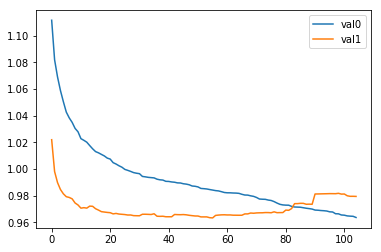

In [42]:
time.sleep(0.2)
deval.plot()

###### ax = xgb.plot_importance(model,height=0.8,)
print(ax.figure.set_size_inches(5,10))

In [43]:
#%env PATH=C:\Program Files (x86)\Graphviz2.38\bin
#ax = xgb.plot_tree(model)
#ax.figure.set_size_inches(20,20)

In [44]:
gain = pd.Series(model.get_booster().get_score(importance_type='gain'))
gain = gain.sort_values(ascending=True)
type(gain)

pandas.core.series.Series

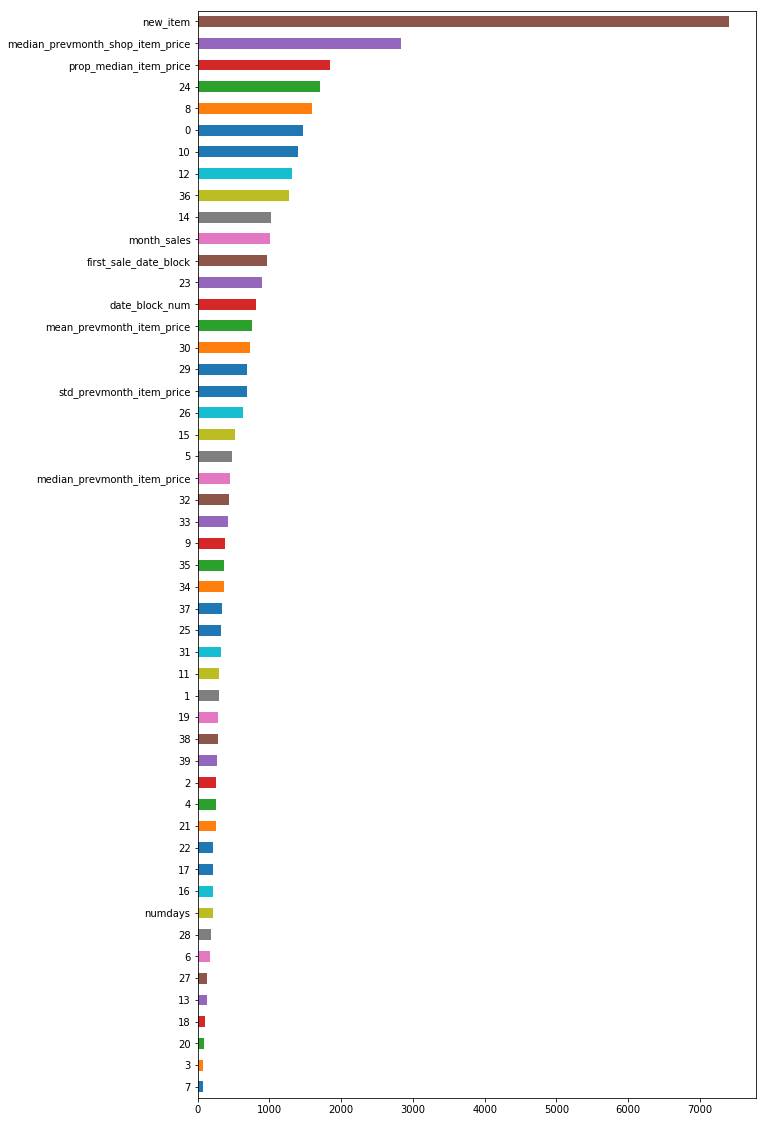

In [45]:
ax = gain.plot(kind='barh')
ax.figure.set_size_inches(10,20)

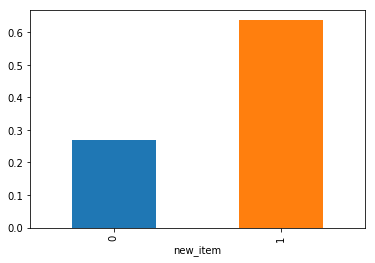

In [46]:
df = x_train[0].copy()
df['target'] = y_train[0]
df.groupby('new_item').target.mean().plot(kind='bar')

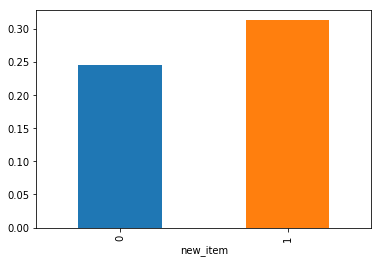

In [47]:
dft = x_test[0].copy()
dft['target'] = y_test[0]
dft.groupby('new_item').target.mean().plot(kind='bar')

In [48]:
#d = pd.DataFrame()
d = {}
coltypes=[  
 'sum_item_sales_back_',
 'sum_shop_sales_back_',
 'item_cnt_month_back_',
 'sum_item_cat_sales_back_',
 'sum_item_cat_shop_sales_back_',
 'sum_city_back_',
 'sum_itemtype_back_',
 'sum_iteminfo_back_',
 'sum_city_item_back_',
 'sum_city_item_cat_back_',
 'sum_itemtype_shop_back_',
 'sum_itemtype_city_back_']
save=[]
for ct in coltypes:
    save.append(gain.filter(regex=ct))
    d[ct] = np.sum(gain.filter(regex=ct))

In [49]:
sorted(d.items(),key=lambda t: t[1],reverse=True)

[('sum_item_sales_back_', 0.0),
 ('sum_shop_sales_back_', 0.0),
 ('item_cnt_month_back_', 0.0),
 ('sum_item_cat_sales_back_', 0.0),
 ('sum_item_cat_shop_sales_back_', 0.0),
 ('sum_city_back_', 0.0),
 ('sum_itemtype_back_', 0.0),
 ('sum_iteminfo_back_', 0.0),
 ('sum_city_item_back_', 0.0),
 ('sum_city_item_cat_back_', 0.0),
 ('sum_itemtype_shop_back_', 0.0),
 ('sum_itemtype_city_back_', 0.0)]

In [50]:
np.sum(save[0])

0.0

In [51]:
len(gain)

50

In [52]:
pd.Series(gain)

7                                     70.524347
3                                     75.156249
20                                    86.975211
18                                   104.849383
13                                   125.861581
27                                   136.806920
6                                    174.632277
28                                   185.719971
numdays                              210.565590
16                                   211.198860
17                                   211.599096
22                                   211.665558
21                                   252.190237
4                                    259.214212
2                                    259.636633
39                                   275.840437
38                                   278.106649
19                                   278.227754
1                                    294.160148
11                                   301.099426
31                                   329

# Retrain model with all data

# Write Submission

In [53]:
#SUB=True

In [54]:
#retrain on all data
#
#
#
#
#
if SUB:
    preds = model.predict(x_test[1])

In [55]:
if SUB:
    preds

In [56]:
if SUB:
    #sample_sub = pd.read_csv('../original_data/sample_submission.csv.gz')
    test0 = pd.read_csv('../original_data/test.csv.gz')

In [57]:
if SUB:
    submission = x_test_1_saved.copy()
    submission['item_cnt_month'] = preds
    submission = test0.merge(submission).drop(['shop_id','item_id'],axis=1)

In [58]:
if SUB:
    submission.to_csv('../gen_data/model3_basic_sub.csv',index=False)
    submission.head()

In [59]:
if SUB:
    submission_adjusted = submission
    submission_adjusted['item_cnt_month'] = 0.2839853/submission_adjusted['item_cnt_month'].mean()*submission_adjusted['item_cnt_month']
    submission.to_csv('../gen_data/model3_basic_sub_adjusted.csv',index=False)
    submission_adjusted.head()